In [47]:
import numpy as np
import matplotlib.pyplot as plt




def calc_lcoe(capFactor,capex,varOM,fixedOM,transmission_cost,
              rD,rL,rT,
              loan_term,lifetime,discount_end=0,
              stor_cost=0,stor_hours=0,rec_sales=0,
              ITC=0,PTC=0):

    installed_cap = 1000    

    years = np.linspace(1,lifetime,lifetime)

    expenditures = []
    discounts = []
    e_gen = []
    loan_balance = []

    # def lfc(capex,r,term):
    #     return capex*r /(1.0-np.power(1.0+r,-term))
    init_balance = capex*installed_cap*(1.0 - ITC)+stor_cost*installed_cap*stor_hours*capFactor
    

    
    cap_payments = init_balance*(rL*(1.0+rL)**(loan_term)/((1+rL)**(loan_term) - 1))
    dep = 1.0/(lifetime)
    bank_payments = []
    balance = init_balance
    for i,t in enumerate(years):

        # Pay down the mortgage
        balance *= (1.0 + rL)
        cap_payments = min(cap_payments,balance)
        intrest = rL*balance
        balance -= cap_payments
        balance = max(balance,0.0)
        bank_payments.append(cap_payments)
        # Calculate the annual gneration
        gen = capFactor*installed_cap*(365*24)

        if discount_end <= 0:
            t_max = t
        else:
            t_max = min(t,discount_end)


        gamma = 1.0/(1+rD)**t_max
        tax_factor = - rT*dep*gamma*init_balance/(1.0-rT)
        principal_payment = max(cap_payments,0.0)-max(min(intrest,cap_payments),0.0)
        # principal_payment = cap_payments-intrest

        # Sum of the expenses for the year
        expenses = principal_payment*gamma/(1.0-rT) + intrest*gamma
        expenses += varOM*gen*gamma + fixedOM*installed_cap*gamma 
        expenses += -rec_sales*gen*gamma + tax_factor - gen*PTC*gamma 
        expenses += transmission_cost*gen*gamma

        # Append the discounted expenses
        expenditures.append(expenses)

        # Append the discounted generation
        e_gen.append(gen*gamma*1.0e-3)

        
        # print(init_balance)

    # print(np.sum(expenditures)/np.sum(e_gen))
    lcoe = np.sum(expenditures)/np.sum(e_gen)
    return lcoe

    # import matplotlib.pyplot as plt

    # plt.plot(expenditures)
    # plt.figure()
    # plt.plot(e_gen)
    # plt.figure()
    # plt.plot(bank_payments)




In [48]:
from types import MethodType
class LcoeAssumptions:

    capacity_factor = 0.92
    lifetime = 60 # y 
    loan_term = 30 # y
    discount_end=0 # 0 means no limit to discounting
    discount_rate = 0.07 # %/100
    intrest_rate = 0.07 # %/100
    tax_rate = 0.21 # %/100

    capex = 12000 # $/kW
    varOM = 3.02-3 # $/kWh
    fixedOM = 122.26 # $/kW-y
    transmission_cost = 0.99e-3 # $/kWh

    PTC = 0.0 # $/kWh
    ITC = 0.0 # %/100
    rec_sales = 0.0 # $/kWh

    # Storage
    stor_cost = 400 # $/kWh - storage capacity
    stor_hours = 0  # kWh/kW(installed generation capacity_factor * capacity)

  

    def __init__(self):

        
        def _calc_lcoe(self,capFactor=self.capacity_factor,capex=self.capex,varOM=self.varOM,fixedOM=self.fixedOM,transmission_cost=self.transmission_cost,
              rD=self.discount_rate,rL=self.intrest_rate,rT=self.tax_rate,
              loan_term=self.loan_term,lifetime=self.lifetime,discount_end=self.discount_end,
              stor_cost=self.stor_cost,stor_hours=self.stor_hours,rec_sales=self.rec_sales,
              ITC=self.ITC,PTC=self.PTC):

            return calc_lcoe(capFactor,capex,varOM,fixedOM,transmission_cost,
              rD,rL,rT,
              loan_term,lifetime,discount_end,
              stor_cost,stor_hours,rec_sales,
              ITC,PTC)

        self.calc_lcoe = MethodType(_calc_lcoe,self)
        return


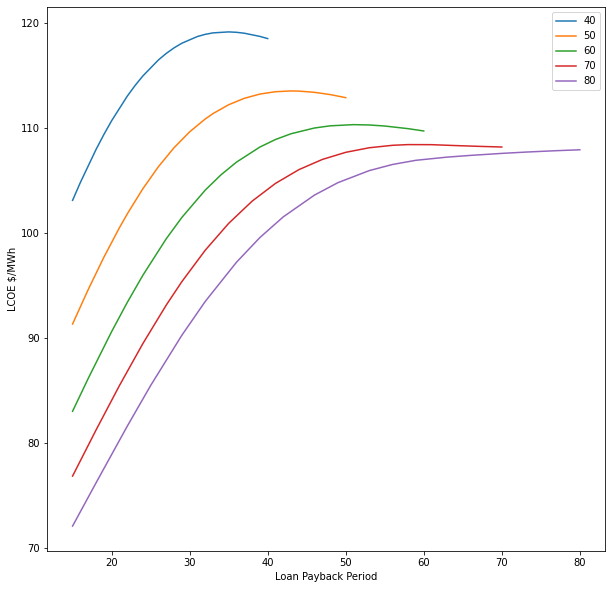

In [51]:


class NuclearBase(LcoeAssumptions):
  
    def __init__(self):
      

        self.capacity_factor = 0.92
        self.lifetime = 80 # y 
        self.loan_term = 30 # y
        self.discount_end=0 # 0 means no limit to discounting
        self.discount_rate = 0.05 # %/100
        self.intrest_rate = 0.05 # %/100
        self.tax_rate = 0.21 # %/100

        self.capex = 12000 # $/kW
        self.varOM = 3.02-3 # $/kWh
        self.fixedOM = 122.26 # $/kW-y
        self.transmission_cost = 0.0 # $/kWh

        self.PTC = 0.0 # $/kWh
        self.ITC = 0.0 # %/100
        self.rec_sales = 0.0 # $/kWh

        # Storage
        self.stor_cost = 0 # $/kWh - storage capacity
        self.stor_hours = 0  # kWh/kW(installed generation capacity_factor * capacity)

        super().__init__()

        return 
    # def calc_lcoe(self,*kwargs):
    #   return super().calc_lcoe(*kwargs)
plt.figure(figsize=(10,10))
nuke_plant = NuclearBase()
nuke_plant.calc_lcoe()
lifetimes = np.int32(np.round(np.linspace(40,nuke_plant.lifetime,5)))

lcoes = []
for life in lifetimes:
    loan_terms = np.int32(np.round(np.linspace(15,life,20)))

    lc = []
    for lt in loan_terms:    
        lc.append(nuke_plant.calc_lcoe(loan_term=lt,lifetime=life,discount_end=lt))
    lcoes.append([loan_terms,lc])

    plt.xlabel('Loan Payback Period')
    plt.ylabel('LCOE $/MWh')
    plt.plot(loan_terms,lc,label=str(life))
    plt.legend(loc='upper right')

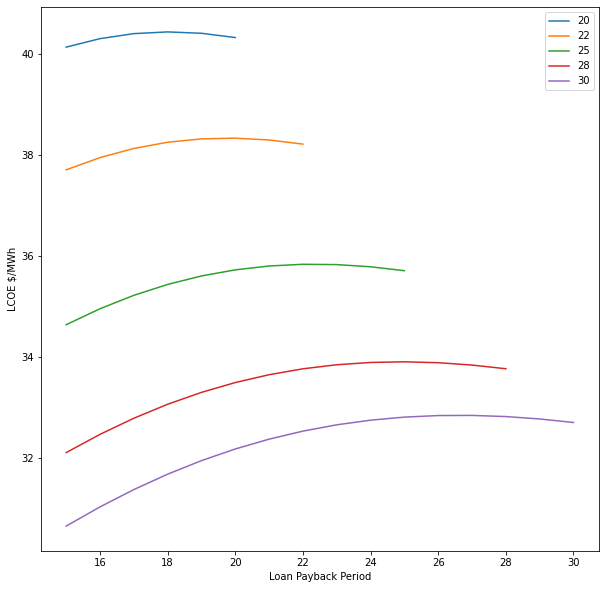

In [58]:
class SolarBase(LcoeAssumptions):
  
    def __init__(self):
      

        self.capacity_factor = 0.3
        self.lifetime = 30 # y 
        self.loan_term = 30 # y
        self.discount_end=-1 # 0 means no limit to discounting
        self.discount_rate = 0.04 # %/100
        self.intrest_rate = 0.04 # %/100
        self.tax_rate = 0.21 # %/100

        self.capex = 1248 # $/kW
        self.varOM = 0.0 # $/kWh
        self.fixedOM = 15.33 # $/kW-y
        self.transmission_cost = 0.0 # $/kWh

        self.PTC = 0.0 # $/kWh
        self.ITC = 0.0 # %/100
        self.rec_sales = 0.0 # $/kWh

        # Storage
        self.stor_cost = 0 # $/kWh - storage capacity
        self.stor_hours = 0  # kWh/kW(installed generation capacity_factor * capacity)

        super().__init__()

        return 
    # def calc_lcoe(self,*kwargs):
    #   return super().calc_lcoe(*kwargs)
plt.figure(figsize=(10,10))
solar_plant = SolarBase()
solar_plant.calc_lcoe()
lifetimes = np.int32(np.round(np.linspace(20,solar_plant.lifetime,5)))

lcoes = []
for life in lifetimes:
    loan_terms = np.int32(np.round(np.linspace(15,life,20)))

    lc = []
    for lt in loan_terms:    
        lc.append(solar_plant.calc_lcoe(loan_term=lt,lifetime=life,discount_end=lt))
    lcoes.append([loan_terms,lc])

    plt.xlabel('Loan Payback Period')
    plt.ylabel('LCOE $/MWh')
    plt.plot(loan_terms,lc,label=str(life))
    plt.legend(loc='upper right')